In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(6)*train_x + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[-8.1176e+00, -1.1929e+01],
        [-7.0258e+00, -1.1271e+01],
        [-6.2118e+00, -1.1028e+01],
        [-5.3887e+00, -1.0421e+01],
        [-4.4615e+00, -1.0152e+01],
        [-4.1511e+00, -9.7630e+00],
        [-3.0646e+00, -9.0165e+00],
        [-2.7632e+00, -8.6126e+00],
        [-2.6755e+00, -8.0787e+00],
        [-1.7300e+00, -7.5557e+00],
        [-1.7009e+00, -7.0560e+00],
        [-1.4305e+00, -6.7959e+00],
        [-8.0094e-01, -5.9346e+00],
        [-7.3699e-01, -5.

In [4]:

len(train_y.shape)

2

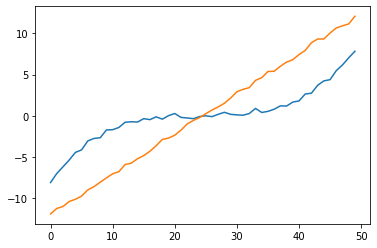

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1^2, 1))
        R = matrix(2, 2, (1, dx2^2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  1.0000e+00,  9.9667e-01,  ..., -6.6522e-03,
          3.3546e-04, -5.0319e-03],
        [ 1.0000e+00,  3.0000e+00,  9.9003e-01,  ...,  6.7948e-02,
         -5.0319e-03,  5.4680e-02],
        [ 9.9667e-01,  9.9003e-01,  1.0000e+00,  ..., -8.7267e-03,
          4.6345e-04, -6.6522e-03],
        ...,
        [-6.6522e-03,  6.7948e-02, -8.7267e-03,  ...,  3.0000e+00,
          9.9003e-01,  2.9502e+00],
        [ 3.3546e-04, -5.0319e-03,  4.6345e-04,  ...,  9.9003e-01,
          1.0000e+00,  1.0000e+00],
        [-5.0319e-03,  5.4680e-02, -6.6522e-03,  ...,  2.9502e+00,
          1.0000e+00,  3.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6527e+01,  0.0000e+00],
        [ 5.1993e+01,  0.0000e+00],
        [ 3.0933e+01,  0.0000e+00],
        [ 2.8484e+01,  0.0000e+00],
        [ 1.7336e+01,  0.0000e+00],
        [ 6.7975e+00,  0.0000e+00],
        [ 4.3840e+00,  0.0000e+00],
        [ 2.5067e+00,  0.0000e+00],
        [ 8.3485e-01,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:646: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052e+00,  1.3499e+00,  1.1007e+00,  ..., -2.0296e-03,
          6.3073e-05, -1.4285e-03],
        [ 1.3499e+00,  4.9462e+00,  1.3334e+00,  ...,  3.3814e-02,
         -1.4285e-03,  2.5184e-02],
        [ 1.1007e+00,  1.3334e+00,  1.1052e+00,  ..., -2.8574e-03,
          9.3601e-05, -2.0296e-03],
        ...,
        [-2.0296e-03,  3.3814e-02, -2.8574e-03,  ...,  4.9462e+00,
          1.3334e+00,  4.8460e+00],
        [ 6.3073e-05, -1.4285e-03,  9.3601e-05,  ...,  1.3334e+00,
          1.1052e+00,  1.3499e+00],
        [-1.4285e-03,  2.5184e-02, -2.0296e-03,  ...,  4.8460e+00,
          1.3499e+00,  4.9462e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3627e+01,  0.0000e+00],
        [ 7.9234e+01,  0.0000e+00],
        [ 4.5257e+01,  0.0000e+00],
        [ 3.8350e+01,  0.0000e+00],
        [ 2.7255e+01,  0.0000e+00],
        [ 1.4183e+01,  0.0000e+00],
        [ 7.0968e+00,  0.0000e+00],
        [ 4.2391e+00,  0.0000e+00],
        [ 2.4565e+00,

tensor([[ 1.3411e+00,  2.3894e+00,  1.3332e+00,  ..., -7.2278e-05,
          8.6540e-07, -4.2413e-05],
        [ 2.3894e+00,  1.2772e+01,  2.3471e+00,  ...,  2.8691e-03,
         -4.2413e-05,  1.7709e-03],
        [ 1.3332e+00,  2.3471e+00,  1.3411e+00,  ..., -1.2160e-04,
          1.5392e-06, -7.2278e-05],
        ...,
        [-7.2278e-05,  2.8691e-03, -1.2160e-04,  ...,  1.2772e+01,
          2.3471e+00,  1.2395e+01],
        [ 8.6540e-07, -4.2413e-05,  1.5392e-06,  ...,  2.3471e+00,
          1.3411e+00,  2.3894e+00],
        [-4.2413e-05,  1.7709e-03, -7.2278e-05,  ...,  1.2395e+01,
          2.3894e+00,  1.2772e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.8340e+02,  0.0000e+00],
        [ 1.7467e+02,  0.0000e+00],
        [ 1.1295e+02,  0.0000e+00],
        [ 9.1939e+01,  0.0000e+00],
        [ 5.2459e+01,  0.0000e+00],
        [ 2.7267e+01,  0.0000e+00],
        [ 3.5514e+01,  0.0000e+00],
        [ 1.1818e+01,  0.0000e+00],
        [ 7.7587e+00,

tensor([[ 1.6036e+00,  3.9189e+00,  1.5906e+00,  ..., -1.0193e-06,
          5.1843e-09, -4.8269e-07],
        [ 3.9189e+00,  2.8730e+01,  3.8238e+00,  ...,  8.0865e-05,
         -4.8269e-07,  4.0161e-05],
        [ 1.5906e+00,  3.8238e+00,  1.6036e+00,  ..., -2.1156e-06,
          1.1421e-08, -1.0193e-06],
        ...,
        [-1.0193e-06,  8.0865e-05, -2.1156e-06,  ...,  2.8730e+01,
          3.8238e+00,  2.7572e+01],
        [ 5.1843e-09, -4.8269e-07,  1.1421e-08,  ...,  3.8238e+00,
          1.6036e+00,  3.9189e+00],
        [-4.8269e-07,  4.0161e-05, -1.0193e-06,  ...,  2.7572e+01,
          3.9189e+00,  2.8730e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.5499e+02,  0.0000e+00],
        [ 3.5469e+02,  0.0000e+00],
        [ 2.3110e+02,  0.0000e+00],
        [ 2.2302e+02,  0.0000e+00],
        [ 1.1901e+02,  0.0000e+00],
        [ 9.7080e+01,  0.0000e+00],
        [ 5.1242e+01,  0.0000e+00],
        [ 3.4733e+01,  0.0000e+00],
        [ 2.4013e+01,

tensor([[ 1.8833e+00,  5.8074e+00,  1.8641e+00,  ..., -1.4102e-08,
          3.6424e-11, -5.4291e-09],
        [ 5.8074e+00,  5.3723e+01,  5.6299e+00,  ...,  1.8394e-06,
         -5.4291e-09,  7.4157e-07],
        [ 1.8641e+00,  5.6299e+00,  1.8833e+00,  ..., -3.5849e-08,
          9.8676e-11, -1.4102e-08],
        ...,
        [-1.4102e-08,  1.8394e-06, -3.5849e-08,  ...,  5.3723e+01,
          5.6299e+00,  5.0996e+01],
        [ 3.6424e-11, -5.4291e-09,  9.8676e-11,  ...,  5.6299e+00,
          1.8833e+00,  5.8074e+00],
        [-5.4291e-09,  7.4157e-07, -1.4102e-08,  ...,  5.0996e+01,
          5.8074e+00,  5.3723e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.1080e+02,  0.0000e+00],
        [ 5.9370e+02,  0.0000e+00],
        [ 4.3675e+02,  0.0000e+00],
        [ 3.9144e+02,  0.0000e+00],
        [ 2.4452e+02,  0.0000e+00],
        [ 2.0213e+02,  0.0000e+00],
        [ 9.9977e+01,  0.0000e+00],
        [ 8.8819e+01,  0.0000e+00],
        [ 3.5806e+01,

tensor([[ 2.1712e+00,  7.7443e+00,  2.1456e+00,  ..., -5.3435e-10,
          8.7987e-13, -1.7596e-10],
        [ 7.7443e+00,  8.2867e+01,  7.4709e+00,  ...,  9.4773e-08,
         -1.7596e-10,  3.2657e-08],
        [ 2.1456e+00,  7.4709e+00,  2.1712e+00,  ..., -1.5831e-09,
          2.7865e-12, -5.3435e-10],
        ...,
        [-5.3435e-10,  9.4773e-08, -1.5831e-09,  ...,  8.2867e+01,
          7.4709e+00,  7.8010e+01],
        [ 8.7987e-13, -1.7596e-10,  2.7865e-12,  ...,  7.4709e+00,
          2.1712e+00,  7.7443e+00],
        [-1.7596e-10,  3.2657e-08, -5.3435e-10,  ...,  7.8010e+01,
          7.7443e+00,  8.2867e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.7971e+02,  0.0000e+00],
        [ 8.7018e+02,  0.0000e+00],
        [ 6.3418e+02,  0.0000e+00],
        [ 6.2091e+02,  0.0000e+00],
        [ 3.6578e+02,  0.0000e+00],
        [ 3.5117e+02,  0.0000e+00],
        [ 1.8371e+02,  0.0000e+00],
        [ 1.4054e+02,  0.0000e+00],
        [ 7.9626e+01,

tensor([[ 2.4590e+00,  9.3502e+00,  2.4281e+00,  ..., -1.1285e-10,
          1.5135e-13, -3.4435e-11],
        [ 9.3502e+00,  1.0666e+02,  8.9985e+00,  ...,  2.2890e-08,
         -3.4435e-11,  7.3068e-09],
        [ 2.4281e+00,  8.9985e+00,  2.4590e+00,  ..., -3.6024e-10,
          5.1723e-13, -1.1285e-10],
        ...,
        [-1.1285e-10,  2.2890e-08, -3.6024e-10,  ...,  1.0666e+02,
          8.9985e+00,  1.0000e+02],
        [ 1.5135e-13, -3.4435e-11,  5.1723e-13,  ...,  8.9985e+00,
          2.4590e+00,  9.3502e+00],
        [-3.4435e-11,  7.3068e-09, -1.1285e-10,  ...,  1.0000e+02,
          9.3502e+00,  1.0666e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0966e+03,  0.0000e+00],
        [ 1.0960e+03,  0.0000e+00],
        [ 8.0815e+02,  0.0000e+00],
        [ 7.8943e+02,  0.0000e+00],
        [ 4.9728e+02,  0.0000e+00],
        [ 4.3851e+02,  0.0000e+00],
        [ 2.5905e+02,  0.0000e+00],
        [ 1.8395e+02,  0.0000e+00],
        [ 1.1043e+02,

tensor([[ 2.7399e+00,  1.0358e+01,  2.7056e+00,  ..., -1.4701e-10,
          2.0089e-13, -4.5179e-11],
        [ 1.0358e+01,  1.1748e+02,  9.9708e+00,  ...,  2.9462e-08,
         -4.5179e-11,  9.4714e-09],
        [ 2.7056e+00,  9.9708e+00,  2.7399e+00,  ..., -4.6606e-10,
          6.8171e-13, -1.4701e-10],
        ...,
        [-1.4701e-10,  2.9462e-08, -4.6606e-10,  ...,  1.1748e+02,
          9.9708e+00,  1.1019e+02],
        [ 2.0089e-13, -4.5179e-11,  6.8171e-13,  ...,  9.9708e+00,
          2.7399e+00,  1.0358e+01],
        [-4.5179e-11,  9.4714e-09, -1.4701e-10,  ...,  1.1019e+02,
          1.0358e+01,  1.1748e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2107e+03,  0.0000e+00],
        [ 1.2102e+03,  0.0000e+00],
        [ 8.8943e+02,  0.0000e+00],
        [ 8.7209e+02,  0.0000e+00],
        [ 5.4536e+02,  0.0000e+00],
        [ 4.8401e+02,  0.0000e+00],
        [ 2.8337e+02,  0.0000e+00],
        [ 2.0178e+02,  0.0000e+00],
        [ 1.2119e+02,

tensor([[ 3.0091e+00,  1.0699e+01,  2.9736e+00,  ..., -8.0197e-10,
          1.3338e-12, -2.6505e-10],
        [ 1.0699e+01,  1.1412e+02,  1.0322e+01,  ...,  1.4130e-07,
         -2.6505e-10,  4.8867e-08],
        [ 2.9736e+00,  1.0322e+01,  3.0091e+00,  ..., -2.3676e-09,
          4.2088e-12, -8.0197e-10],
        ...,
        [-8.0197e-10,  1.4130e-07, -2.3676e-09,  ...,  1.1412e+02,
          1.0322e+01,  1.0746e+02],
        [ 1.3338e-12, -2.6505e-10,  4.2088e-12,  ...,  1.0322e+01,
          3.0091e+00,  1.0699e+01],
        [-2.6505e-10,  4.8867e-08, -8.0197e-10,  ...,  1.0746e+02,
          1.0699e+01,  1.1412e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2135e+03,  0.0000e+00],
        [ 1.1996e+03,  0.0000e+00],
        [ 8.7481e+02,  0.0000e+00],
        [ 8.5455e+02,  0.0000e+00],
        [ 5.0221e+02,  0.0000e+00],
        [ 4.8448e+02,  0.0000e+00],
        [ 2.5168e+02,  0.0000e+00],
        [ 1.9368e+02,  0.0000e+00],
        [ 1.0905e+02,

tensor([[ 3.2646e+00,  1.0475e+01,  3.2299e+00,  ..., -1.0147e-08,
          2.3230e-11, -3.7519e-09],
        [ 1.0475e+01,  1.0083e+02,  1.0142e+01,  ...,  1.4398e-06,
         -3.7519e-09,  5.5735e-07],
        [ 3.2299e+00,  1.0142e+01,  3.2646e+00,  ..., -2.6839e-08,
          6.5527e-11, -1.0147e-08],
        ...,
        [-1.0147e-08,  1.4398e-06, -2.6839e-08,  ...,  1.0083e+02,
          1.0142e+01,  9.5504e+01],
        [ 2.3230e-11, -3.7519e-09,  6.5527e-11,  ...,  1.0142e+01,
          3.2646e+00,  1.0475e+01],
        [-3.7519e-09,  5.5735e-07, -1.0147e-08,  ...,  9.5504e+01,
          1.0475e+01,  1.0083e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1264e+03,  0.0000e+00],
        [ 1.0976e+03,  0.0000e+00],
        [ 8.0957e+02,  0.0000e+00],
        [ 7.3867e+02,  0.0000e+00],
        [ 4.5234e+02,  0.0000e+00],
        [ 3.9702e+02,  0.0000e+00],
        [ 1.8209e+02,  0.0000e+00],
        [ 1.8196e+02,  0.0000e+00],
        [ 7.5426e+01,

tensor([[ 3.5074e+00,  9.8739e+00,  3.4747e+00,  ..., -1.7155e-07,
          5.8103e-10, -7.2039e-08],
        [ 9.8739e+00,  8.3389e+01,  9.5982e+00,  ...,  1.8436e-05,
         -7.2039e-08,  8.1113e-06],
        [ 3.4747e+00,  9.5982e+00,  3.5074e+00,  ..., -4.0054e-07,
          1.4432e-09, -1.7155e-07],
        ...,
        [-1.7155e-07,  1.8436e-05, -4.0054e-07,  ...,  8.3389e+01,
          9.5982e+00,  7.9521e+01],
        [ 5.8103e-10, -7.2039e-08,  1.4432e-09,  ...,  9.5982e+00,
          3.5074e+00,  9.8739e+00],
        [-7.2039e-08,  8.1113e-06, -1.7155e-07,  ...,  7.9521e+01,
          9.8739e+00,  8.3389e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.8317e+02,  0.0000e+00],
        [ 9.5874e+02,  0.0000e+00],
        [ 6.8659e+02,  0.0000e+00],
        [ 6.1039e+02,  0.0000e+00],
        [ 3.8035e+02,  0.0000e+00],
        [ 2.8676e+02,  0.0000e+00],
        [ 1.6276e+02,  0.0000e+00],
        [ 1.1160e+02,  0.0000e+00],
        [ 6.6983e+01,

tensor([[ 3.7416e+00,  9.0981e+00,  3.7114e+00,  ..., -2.5842e-06,
          1.3330e-08, -1.2286e-06],
        [ 9.0981e+00,  6.6369e+01,  8.8784e+00,  ...,  2.0283e-04,
         -1.2286e-06,  1.0113e-04],
        [ 3.7114e+00,  8.8784e+00,  3.7416e+00,  ..., -5.3431e-06,
          2.9250e-08, -2.5842e-06],
        ...,
        [-2.5842e-06,  2.0283e-04, -5.3431e-06,  ...,  6.6369e+01,
          8.8784e+00,  6.3705e+01],
        [ 1.3330e-08, -1.2286e-06,  2.9250e-08,  ...,  8.8784e+00,
          3.7416e+00,  9.0981e+00],
        [-1.2286e-06,  1.0113e-04, -2.5842e-06,  ...,  6.3705e+01,
          9.0981e+00,  6.6369e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.2222e+02,  0.0000e+00],
        [ 8.2053e+02,  0.0000e+00],
        [ 5.3300e+02,  0.0000e+00],
        [ 5.1662e+02,  0.0000e+00],
        [ 2.7347e+02,  0.0000e+00],
        [ 2.2481e+02,  0.0000e+00],
        [ 1.1751e+02,  0.0000e+00],
        [ 8.0854e+01,  0.0000e+00],
        [ 5.4948e+01,

tensor([[ 3.9734e+00,  8.2987e+00,  3.9458e+00,  ..., -2.8059e-05,
          2.2018e-07, -1.4907e-05],
        [ 8.2987e+00,  5.1997e+01,  8.1264e+00,  ...,  1.5824e-03,
         -1.4907e-05,  8.8281e-04],
        [ 3.9458e+00,  8.1264e+00,  3.9734e+00,  ..., -5.2035e-05,
          4.3244e-07, -2.8059e-05],
        ...,
        [-2.8059e-05,  1.5824e-03, -5.2035e-05,  ...,  5.1997e+01,
          8.1264e+00,  5.0202e+01],
        [ 2.2018e-07, -1.4907e-05,  4.3244e-07,  ...,  8.1264e+00,
          3.9734e+00,  8.2987e+00],
        [-1.4907e-05,  8.8281e-04, -2.8059e-05,  ...,  5.0202e+01,
          8.2987e+00,  5.1997e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.9651e+02,  0.0000e+00],
        [ 6.7108e+02,  0.0000e+00],
        [ 4.3977e+02,  0.0000e+00],
        [ 3.9190e+02,  0.0000e+00],
        [ 1.9704e+02,  0.0000e+00],
        [ 1.7508e+02,  0.0000e+00],
        [ 8.5601e+01,  0.0000e+00],
        [ 6.8165e+01,  0.0000e+00],
        [ 3.2862e+01,

tensor([[ 4.2117e+00,  7.5915e+00,  4.1865e+00,  ..., -1.9816e-04,
          2.3018e-06, -1.1550e-04],
        [ 7.5915e+00,  4.1050e+01,  7.4554e+00,  ...,  8.0720e-03,
         -1.1550e-04,  4.9481e-03],
        [ 4.1865e+00,  7.4554e+00,  4.2117e+00,  ..., -3.3560e-04,
          4.1215e-06, -1.9816e-04],
        ...,
        [-1.9816e-04,  8.0720e-03, -3.3560e-04,  ...,  4.1050e+01,
          7.4554e+00,  3.9826e+01],
        [ 2.3018e-06, -1.1550e-04,  4.1215e-06,  ...,  7.4554e+00,
          4.2117e+00,  7.5915e+00],
        [-1.1550e-04,  4.9481e-03, -1.9816e-04,  ...,  3.9826e+01,
          7.5915e+00,  4.1050e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.8683e+02,  0.0000e+00],
        [ 5.5857e+02,  0.0000e+00],
        [ 3.6269e+02,  0.0000e+00],
        [ 2.9563e+02,  0.0000e+00],
        [ 1.6838e+02,  0.0000e+00],
        [ 1.1441e+02,  0.0000e+00],
        [ 8.7105e+01,  0.0000e+00],
        [ 3.8826e+01,  0.0000e+00],
        [ 2.4873e+01,

tensor([[ 4.4670e+00,  7.0418e+00,  4.4436e+00,  ..., -9.0681e-04,
          1.4894e-05, -5.6874e-04],
        [ 7.0418e+00,  3.3302e+01,  6.9313e+00,  ...,  2.7328e-02,
         -5.6874e-04,  1.8057e-02],
        [ 4.4436e+00,  6.9313e+00,  4.4670e+00,  ..., -1.4293e-03,
          2.4791e-05, -9.0681e-04],
        ...,
        [-9.0681e-04,  2.7328e-02, -1.4293e-03,  ...,  3.3302e+01,
          6.9313e+00,  3.2433e+01],
        [ 1.4894e-05, -5.6874e-04,  2.4791e-05,  ...,  6.9313e+00,
          4.4670e+00,  7.0418e+00],
        [-5.6874e-04,  1.8057e-02, -9.0681e-04,  ...,  3.2433e+01,
          7.0418e+00,  3.3302e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.9882e+02,  0.0000e+00],
        [ 4.8452e+02,  0.0000e+00],
        [ 2.9053e+02,  0.0000e+00],
        [ 2.4857e+02,  0.0000e+00],
        [ 1.3097e+02,  0.0000e+00],
        [ 1.0921e+02,  0.0000e+00],
        [ 6.2809e+01,  0.0000e+00],
        [ 2.6689e+01,  0.0000e+00],
        [ 2.0819e+01,

tensor([[ 4.7508e+00,  6.6955e+00,  4.7286e+00,  ..., -2.7653e-03,
          6.0290e-05, -1.8310e-03],
        [ 6.6955e+00,  2.8309e+01,  6.6015e+00,  ...,  6.4467e-02,
         -1.8310e-03,  4.5047e-02],
        [ 4.7286e+00,  6.6015e+00,  4.7508e+00,  ..., -4.1333e-03,
          9.5074e-05, -2.7653e-03],
        ...,
        [-2.7653e-03,  6.4467e-02, -4.1333e-03,  ...,  2.8309e+01,
          6.6015e+00,  2.7648e+01],
        [ 6.0290e-05, -1.8310e-03,  9.5074e-05,  ...,  6.6015e+00,
          4.7508e+00,  6.6955e+00],
        [-1.8310e-03,  4.5047e-02, -2.7653e-03,  ...,  2.7648e+01,
          6.6955e+00,  2.8309e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.3960e+02,  0.0000e+00],
        [ 4.3738e+02,  0.0000e+00],
        [ 2.3611e+02,  0.0000e+00],
        [ 2.2935e+02,  0.0000e+00],
        [ 1.1722e+02,  0.0000e+00],
        [ 9.9064e+01,  0.0000e+00],
        [ 4.5209e+01,  0.0000e+00],
        [ 2.2772e+01,  0.0000e+00],
        [ 1.7231e+01,

tensor([[ 5.0751e+00,  6.5892e+00,  5.0531e+00,  ..., -5.8531e-03,
          1.5650e-04, -4.0177e-03],
        [ 6.5892e+00,  2.5665e+01,  6.5040e+00,  ...,  1.1269e-01,
         -4.0177e-03,  8.1754e-02],
        [ 5.0531e+00,  6.5040e+00,  5.0751e+00,  ..., -8.4449e-03,
          2.3809e-04, -5.8531e-03],
        ...,
        [-5.8531e-03,  1.1269e-01, -8.4449e-03,  ...,  2.5665e+01,
          6.5040e+00,  2.5113e+01],
        [ 1.5650e-04, -4.0177e-03,  2.3809e-04,  ...,  6.5040e+00,
          5.0751e+00,  6.5892e+00],
        [-4.0177e-03,  8.1754e-02, -5.8531e-03,  ...,  2.5113e+01,
          6.5892e+00,  2.5665e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.1860e+02,  0.0000e+00],
        [ 4.0471e+02,  0.0000e+00],
        [ 2.2310e+02,  0.0000e+00],
        [ 2.0481e+02,  0.0000e+00],
        [ 1.2601e+02,  0.0000e+00],
        [ 8.0360e+01,  0.0000e+00],
        [ 3.7867e+01,  0.0000e+00],
        [ 2.1414e+01,  0.0000e+00],
        [ 1.4276e+01,

tensor([[ 5.4476e+00,  6.7226e+00,  5.4252e+00,  ..., -9.2725e-03,
          2.8096e-04, -6.4993e-03],
        [ 6.7226e+00,  2.4888e+01,  6.6400e+00,  ...,  1.5832e-01,
         -6.4993e-03,  1.1741e-01],
        [ 5.4252e+00,  6.6400e+00,  5.4476e+00,  ..., -1.3107e-02,
          4.1866e-04, -9.2725e-03],
        ...,
        [-9.2725e-03,  1.5832e-01, -1.3107e-02,  ...,  2.4888e+01,
          6.6400e+00,  2.4379e+01],
        [ 2.8096e-04, -6.4993e-03,  4.1866e-04,  ...,  6.6400e+00,
          5.4476e+00,  6.7226e+00],
        [-6.4993e-03,  1.1741e-01, -9.2725e-03,  ...,  2.4379e+01,
          6.7226e+00,  2.4888e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.1828e+02,  0.0000e+00],
        [ 3.9759e+02,  0.0000e+00],
        [ 2.2582e+02,  0.0000e+00],
        [ 1.9372e+02,  0.0000e+00],
        [ 1.3469e+02,  0.0000e+00],
        [ 7.2435e+01,  0.0000e+00],
        [ 3.5817e+01,  0.0000e+00],
        [ 2.1244e+01,  0.0000e+00],
        [ 1.2633e+01,

tensor([[ 5.8712e+00,  7.0757e+00,  5.8477e+00,  ..., -1.1883e-02,
          3.8158e-04, -8.4075e-03],
        [ 7.0757e+00,  2.5582e+01,  6.9908e+00,  ...,  1.9174e-01,
         -8.4075e-03,  1.4361e-01],
        [ 5.8477e+00,  6.9908e+00,  5.8712e+00,  ..., -1.6643e-02,
          5.6331e-04, -1.1883e-02],
        ...,
        [-1.1883e-02,  1.9174e-01, -1.6643e-02,  ...,  2.5582e+01,
          6.9908e+00,  2.5071e+01],
        [ 3.8158e-04, -8.4075e-03,  5.6331e-04,  ...,  6.9908e+00,
          5.8712e+00,  7.0757e+00],
        [-8.4075e-03,  1.4361e-01, -1.1883e-02,  ...,  2.5071e+01,
          7.0757e+00,  2.5582e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.3589e+02,  0.0000e+00],
        [ 4.1133e+02,  0.0000e+00],
        [ 2.3659e+02,  0.0000e+00],
        [ 1.9759e+02,  0.0000e+00],
        [ 1.4412e+02,  0.0000e+00],
        [ 7.1962e+01,  0.0000e+00],
        [ 3.6596e+01,  0.0000e+00],
        [ 2.2031e+01,  0.0000e+00],
        [ 1.2333e+01,

tensor([[ 6.3443e+00,  7.6250e+00,  6.3189e+00,  ..., -1.3094e-02,
          4.2331e-04, -9.2746e-03],
        [ 7.6250e+00,  2.7493e+01,  7.5337e+00,  ...,  2.0992e-01,
         -9.2746e-03,  1.5740e-01],
        [ 6.3189e+00,  7.5337e+00,  6.3443e+00,  ..., -1.8321e-02,
          6.2424e-04, -1.3094e-02],
        ...,
        [-1.3094e-02,  2.0992e-01, -1.8321e-02,  ...,  2.7493e+01,
          7.5337e+00,  2.6945e+01],
        [ 4.2331e-04, -9.2746e-03,  6.2424e-04,  ...,  7.5337e+00,
          6.3443e+00,  7.6250e+00],
        [-9.2746e-03,  1.5740e-01, -1.3094e-02,  ...,  2.6945e+01,
          7.6250e+00,  2.7493e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.6919e+02,  0.0000e+00],
        [ 4.4240e+02,  0.0000e+00],
        [ 2.5481e+02,  0.0000e+00],
        [ 2.1222e+02,  0.0000e+00],
        [ 1.5554e+02,  0.0000e+00],
        [ 7.7036e+01,  0.0000e+00],
        [ 3.9311e+01,  0.0000e+00],
        [ 2.3699e+01,  0.0000e+00],
        [ 1.3172e+01,

tensor([[ 6.8613e+00,  8.3432e+00,  6.8335e+00,  ..., -1.3015e-02,
          4.0890e-04, -9.1766e-03],
        [ 8.3432e+00,  3.0436e+01,  8.2422e+00,  ...,  2.1456e-01,
         -9.1766e-03,  1.6010e-01],
        [ 6.8335e+00,  8.2422e+00,  6.8613e+00,  ..., -1.8293e-02,
          6.0575e-04, -1.3015e-02],
        ...,
        [-1.3015e-02,  2.1456e-01, -1.8293e-02,  ...,  3.0436e+01,
          8.2422e+00,  2.9822e+01],
        [ 4.0890e-04, -9.1766e-03,  6.0575e-04,  ...,  8.2422e+00,
          6.8613e+00,  8.3432e+00],
        [-9.1766e-03,  1.6010e-01, -1.3015e-02,  ...,  2.9822e+01,
          8.3432e+00,  3.0436e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.1592e+02,  0.0000e+00],
        [ 4.8816e+02,  0.0000e+00],
        [ 2.7948e+02,  0.0000e+00],
        [ 2.3565e+02,  0.0000e+00],
        [ 1.6898e+02,  0.0000e+00],
        [ 8.6720e+01,  0.0000e+00],
        [ 4.3622e+01,  0.0000e+00],
        [ 2.6128e+01,  0.0000e+00],
        [ 1.4971e+01,

tensor([[ 7.4133e+00,  9.1935e+00,  7.3827e+00,  ..., -1.2165e-02,
          3.6417e-04, -8.5096e-03],
        [ 9.1935e+00,  3.4204e+01,  9.0799e+00,  ...,  2.1014e-01,
         -8.5096e-03,  1.5551e-01],
        [ 7.3827e+00,  9.0799e+00,  7.4133e+00,  ..., -1.7229e-02,
          5.4372e-04, -1.2165e-02],
        ...,
        [-1.2165e-02,  2.1014e-01, -1.7229e-02,  ...,  3.4204e+01,
          9.0799e+00,  3.3501e+01],
        [ 3.6417e-04, -8.5096e-03,  5.4372e-04,  ...,  9.0799e+00,
          7.4133e+00,  9.1935e+00],
        [-8.5096e-03,  1.5551e-01, -1.2165e-02,  ...,  3.3501e+01,
          9.1935e+00,  3.4204e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.7319e+02,  0.0000e+00],
        [ 5.4569e+02,  0.0000e+00],
        [ 3.0909e+02,  0.0000e+00],
        [ 2.6677e+02,  0.0000e+00],
        [ 1.8347e+02,  0.0000e+00],
        [ 1.0026e+02,  0.0000e+00],
        [ 4.9305e+01,  0.0000e+00],
        [ 2.9137e+01,  0.0000e+00],
        [ 1.7536e+01,

tensor([[ 7.9889e+00,  1.0124e+01,  7.9552e+00,  ..., -1.1129e-02,
          3.1591e-04, -7.7171e-03],
        [ 1.0124e+01,  3.8489e+01,  9.9962e+00,  ...,  2.0237e-01,
         -7.7171e-03,  1.4838e-01],
        [ 7.9552e+00,  9.9962e+00,  7.9889e+00,  ..., -1.5899e-02,
          4.7582e-04, -1.1129e-02],
        ...,
        [-1.1129e-02,  2.0237e-01, -1.5899e-02,  ...,  3.8489e+01,
          9.9962e+00,  3.7681e+01],
        [ 3.1591e-04, -7.7171e-03,  4.7582e-04,  ...,  9.9962e+00,
          7.9889e+00,  1.0124e+01],
        [-7.7171e-03,  1.4838e-01, -1.1129e-02,  ...,  3.7681e+01,
          1.0124e+01,  3.8489e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.3685e+02,  0.0000e+00],
        [ 6.1063e+02,  0.0000e+00],
        [ 3.4158e+02,  0.0000e+00],
        [ 3.0325e+02,  0.0000e+00],
        [ 1.9823e+02,  0.0000e+00],
        [ 1.1640e+02,  0.0000e+00],
        [ 5.5993e+01,  0.0000e+00],
        [ 3.2478e+01,  0.0000e+00],
        [ 2.0562e+01,

tensor([[ 8.5753e+00,  1.1067e+01,  8.5385e+00,  ..., -1.0370e-02,
          2.8142e-04, -7.1364e-03],
        [ 1.1067e+01,  4.2848e+01,  1.0925e+01,  ...,  1.9685e-01,
         -7.1364e-03,  1.4319e-01],
        [ 8.5385e+00,  1.0925e+01,  8.5753e+00,  ..., -1.4925e-02,
          4.2708e-04, -1.0370e-02],
        ...,
        [-1.0370e-02,  1.9685e-01, -1.4925e-02,  ...,  4.2848e+01,
          1.0925e+01,  4.1931e+01],
        [ 2.8142e-04, -7.1364e-03,  4.2708e-04,  ...,  1.0925e+01,
          8.5753e+00,  1.1067e+01],
        [-7.1364e-03,  1.4319e-01, -1.0370e-02,  ...,  4.1931e+01,
          1.1067e+01,  4.2848e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.0136e+02,  0.0000e+00],
        [ 6.7667e+02,  0.0000e+00],
        [ 3.7440e+02,  0.0000e+00],
        [ 3.4082e+02,  0.0000e+00],
        [ 2.1292e+02,  0.0000e+00],
        [ 1.3301e+02,  0.0000e+00],
        [ 6.2973e+01,  0.0000e+00],
        [ 3.5852e+01,  0.0000e+00],
        [ 2.3610e+01,

tensor([[ 9.1601e+00,  1.1947e+01,  9.1204e+00,  ..., -1.0191e-02,
          2.6943e-04, -6.9818e-03],
        [ 1.1947e+01,  4.6746e+01,  1.1792e+01,  ...,  1.9831e-01,
         -6.9818e-03,  1.4358e-01],
        [ 9.1204e+00,  1.1792e+01,  9.1601e+00,  ..., -1.4731e-02,
          4.1069e-04, -1.0191e-02],
        ...,
        [-1.0191e-02,  1.9831e-01, -1.4731e-02,  ...,  4.6746e+01,
          1.1792e+01,  4.5736e+01],
        [ 2.6943e-04, -6.9818e-03,  4.1069e-04,  ...,  1.1792e+01,
          9.1601e+00,  1.1947e+01],
        [-6.9818e-03,  1.4358e-01, -1.0191e-02,  ...,  4.5736e+01,
          1.1947e+01,  4.6746e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.6038e+02,  0.0000e+00],
        [ 7.3629e+02,  0.0000e+00],
        [ 4.0477e+02,  0.0000e+00],
        [ 3.7395e+02,  0.0000e+00],
        [ 2.2742e+02,  0.0000e+00],
        [ 1.4731e+02,  0.0000e+00],
        [ 6.9184e+01,  0.0000e+00],
        [ 3.8918e+01,  0.0000e+00],
        [ 2.6181e+01,

tensor([[ 9.7326e+00,  1.2696e+01,  9.6904e+00,  ..., -1.0811e-02,
          2.8570e-04, -7.4064e-03],
        [ 1.2696e+01,  4.9687e+01,  1.2531e+01,  ...,  2.1048e-01,
         -7.4064e-03,  1.5238e-01],
        [ 9.6904e+00,  1.2531e+01,  9.7326e+00,  ..., -1.5629e-02,
          4.3553e-04, -1.0811e-02],
        ...,
        [-1.0811e-02,  2.1048e-01, -1.5629e-02,  ...,  4.9687e+01,
          1.2531e+01,  4.8613e+01],
        [ 2.8570e-04, -7.4064e-03,  4.3553e-04,  ...,  1.2531e+01,
          9.7326e+00,  1.2696e+01],
        [-7.4064e-03,  1.5238e-01, -1.0811e-02,  ...,  4.8613e+01,
          1.2696e+01,  4.9687e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.0812e+02,  0.0000e+00],
        [ 7.8258e+02,  0.0000e+00],
        [ 4.3017e+02,  0.0000e+00],
        [ 3.9752e+02,  0.0000e+00],
        [ 2.4163e+02,  0.0000e+00],
        [ 1.5662e+02,  0.0000e+00],
        [ 7.3546e+01,  0.0000e+00],
        [ 4.1363e+01,  0.0000e+00],
        [ 2.7836e+01,

tensor([[ 1.0286e+01,  1.3270e+01,  1.0242e+01,  ..., -1.2470e-02,
          3.3867e-04, -8.5826e-03],
        [ 1.3270e+01,  5.1363e+01,  1.3100e+01,  ...,  2.3653e-01,
         -8.5826e-03,  1.7208e-01],
        [ 1.0242e+01,  1.3100e+01,  1.0286e+01,  ..., -1.7945e-02,
          5.1389e-04, -1.2470e-02],
        ...,
        [-1.2470e-02,  2.3653e-01, -1.7945e-02,  ...,  5.1363e+01,
          1.3100e+01,  5.0264e+01],
        [ 3.3867e-04, -8.5826e-03,  5.1389e-04,  ...,  1.3100e+01,
          1.0286e+01,  1.3270e+01],
        [-8.5826e-03,  1.7208e-01, -1.2470e-02,  ...,  5.0264e+01,
          1.3270e+01,  5.1363e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.4089e+02,  0.0000e+00],
        [ 8.1120e+02,  0.0000e+00],
        [ 4.4892e+02,  0.0000e+00],
        [ 4.0847e+02,  0.0000e+00],
        [ 2.5539e+02,  0.0000e+00],
        [ 1.5937e+02,  0.0000e+00],
        [ 7.5472e+01,  0.0000e+00],
        [ 4.2983e+01,  0.0000e+00],
        [ 2.8287e+01,

tensor([[ 1.0817e+01,  1.3658e+01,  1.0772e+01,  ..., -1.5496e-02,
          4.4383e-04, -1.0761e-02],
        [ 1.3658e+01,  5.1736e+01,  1.3486e+01,  ...,  2.7935e-01,
         -1.0761e-02,  2.0515e-01],
        [ 1.0772e+01,  1.3486e+01,  1.0817e+01,  ..., -2.2105e-02,
          6.6749e-04, -1.5496e-02],
        ...,
        [-1.5496e-02,  2.7935e-01, -2.2105e-02,  ...,  5.1736e+01,
          1.3486e+01,  5.0653e+01],
        [ 4.4383e-04, -1.0761e-02,  6.6749e-04,  ...,  1.3486e+01,
          1.0817e+01,  1.3658e+01],
        [-1.0761e-02,  2.0515e-01, -1.5496e-02,  ...,  5.0653e+01,
          1.3658e+01,  5.1736e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.5788e+02,  0.0000e+00],
        [ 8.2155e+02,  0.0000e+00],
        [ 4.6055e+02,  0.0000e+00],
        [ 4.0688e+02,  0.0000e+00],
        [ 2.6833e+02,  0.0000e+00],
        [ 1.5563e+02,  0.0000e+00],
        [ 7.5131e+01,  0.0000e+00],
        [ 4.3728e+01,  0.0000e+00],
        [ 2.7457e+01,

tensor([[ 1.1327e+01,  1.3878e+01,  1.1281e+01,  ..., -2.0334e-02,
          6.2713e-04, -1.4294e-02],
        [ 1.3878e+01,  5.1008e+01,  1.3708e+01,  ...,  3.4128e-01,
         -1.4294e-02,  2.5386e-01],
        [ 1.1281e+01,  1.3708e+01,  1.1327e+01,  ..., -2.8663e-02,
          9.3182e-04, -2.0334e-02],
        ...,
        [-2.0334e-02,  3.4128e-01, -2.8663e-02,  ...,  5.1008e+01,
          1.3708e+01,  4.9972e+01],
        [ 6.2713e-04, -1.4294e-02,  9.3182e-04,  ...,  1.3708e+01,
          1.1327e+01,  1.3878e+01],
        [-1.4294e-02,  2.5386e-01, -2.0334e-02,  ...,  4.9972e+01,
          1.3878e+01,  5.1008e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.6087e+02,  0.0000e+00],
        [ 8.1643e+02,  0.0000e+00],
        [ 4.6555e+02,  0.0000e+00],
        [ 3.9593e+02,  0.0000e+00],
        [ 2.7958e+02,  0.0000e+00],
        [ 1.4692e+02,  0.0000e+00],
        [ 7.3248e+01,  0.0000e+00],
        [ 4.3664e+01,  0.0000e+00],
        [ 2.5502e+01,

tensor([[ 1.1821e+01,  1.3967e+01,  1.1774e+01,  ..., -2.7520e-02,
          9.2734e-04, -1.9621e-02],
        [ 1.3967e+01,  4.9513e+01,  1.3803e+01,  ...,  4.2357e-01,
         -1.9621e-02,  3.1982e-01],
        [ 1.1774e+01,  1.3803e+01,  1.1821e+01,  ..., -3.8256e-02,
          1.3586e-03, -2.7520e-02],
        ...,
        [-2.7520e-02,  4.2357e-01, -3.8256e-02,  ...,  4.9513e+01,
          1.3803e+01,  4.8543e+01],
        [ 9.2734e-04, -1.9621e-02,  1.3586e-03,  ...,  1.3803e+01,
          1.1821e+01,  1.3967e+01],
        [-1.9621e-02,  3.1982e-01, -2.7520e-02,  ...,  4.8543e+01,
          1.3967e+01,  4.9513e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.5324e+02,  0.0000e+00],
        [ 8.0067e+02,  0.0000e+00],
        [ 4.6495e+02,  0.0000e+00],
        [ 3.8147e+02,  0.0000e+00],
        [ 2.8710e+02,  0.0000e+00],
        [ 1.3544e+02,  0.0000e+00],
        [ 7.0642e+01,  0.0000e+00],
        [ 4.2900e+01,  0.0000e+00],
        [ 2.2781e+01,

tensor([[ 1.2304e+01,  1.3970e+01,  1.2258e+01,  ..., -3.7631e-02,
          1.3975e-03, -2.7237e-02],
        [ 1.3970e+01,  4.7585e+01,  1.3812e+01,  ...,  5.2597e-01,
         -2.7237e-02,  4.0355e-01],
        [ 1.2258e+01,  1.3812e+01,  1.2304e+01,  ..., -5.1547e-02,
          2.0170e-03, -3.7631e-02],
        ...,
        [-3.7631e-02,  5.2597e-01, -5.1547e-02,  ...,  4.7585e+01,
          1.3812e+01,  4.6689e+01],
        [ 1.3975e-03, -2.7237e-02,  2.0170e-03,  ...,  1.3812e+01,
          1.2304e+01,  1.3970e+01],
        [-2.7237e-02,  4.0355e-01, -3.7631e-02,  ...,  4.6689e+01,
          1.3970e+01,  4.7585e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3862e+02,  0.0000e+00],
        [ 7.7936e+02,  0.0000e+00],
        [ 4.5988e+02,  0.0000e+00],
        [ 2.8690e+02,  0.0000e+00],
        [ 3.7132e+02,  0.0000e+00],
        [ 1.2327e+02,  0.0000e+00],
        [ 6.7881e+01,  0.0000e+00],
        [ 4.1534e+01,  0.0000e+00],
        [ 1.9726e+01,

tensor([[ 1.2787e+01,  1.3924e+01,  1.2740e+01,  ..., -5.1257e-02,
          2.1062e-03, -3.7665e-02],
        [ 1.3924e+01,  4.5484e+01,  1.3772e+01,  ...,  6.4697e-01,
         -3.7665e-02,  5.0450e-01],
        [ 1.2740e+01,  1.3772e+01,  1.2787e+01,  ..., -6.9179e-02,
          2.9947e-03, -5.1257e-02],
        ...,
        [-5.1257e-02,  6.4697e-01, -6.9179e-02,  ...,  4.5484e+01,
          1.3772e+01,  4.4663e+01],
        [ 2.1062e-03, -3.7665e-02,  2.9947e-03,  ...,  1.3772e+01,
          1.2787e+01,  1.3924e+01],
        [-3.7665e-02,  5.0450e-01, -5.1257e-02,  ...,  4.4663e+01,
          1.3924e+01,  4.5484e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.2008e+02,  0.0000e+00],
        [ 7.5663e+02,  0.0000e+00],
        [ 4.5128e+02,  0.0000e+00],
        [ 3.7119e+02,  0.0000e+00],
        [ 2.7627e+02,  0.0000e+00],
        [ 1.1184e+02,  0.0000e+00],
        [ 6.5231e+01,  0.0000e+00],
        [ 3.9643e+01,  0.0000e+00],
        [ 1.6704e+01,

tensor([[ 1.3275e+01,  1.3856e+01,  1.3229e+01,  ..., -6.8974e-02,
          3.1390e-03, -5.1435e-02],
        [ 1.3856e+01,  4.3385e+01,  1.3712e+01,  ...,  7.8409e-01,
         -5.1435e-02,  6.2124e-01],
        [ 1.3229e+01,  1.3712e+01,  1.3275e+01,  ..., -9.1755e-02,
          4.3983e-03, -6.8974e-02],
        ...,
        [-6.8974e-02,  7.8409e-01, -9.1755e-02,  ...,  4.3385e+01,
          1.3712e+01,  4.2634e+01],
        [ 3.1390e-03, -5.1435e-02,  4.3983e-03,  ...,  1.3712e+01,
          1.3275e+01,  1.3856e+01],
        [-5.1435e-02,  6.2124e-01, -6.8974e-02,  ...,  4.2634e+01,
          1.3856e+01,  4.3385e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.9990e+02,  0.0000e+00],
        [ 7.3531e+02,  0.0000e+00],
        [ 4.3997e+02,  0.0000e+00],
        [ 3.7950e+02,  0.0000e+00],
        [ 2.5876e+02,  0.0000e+00],
        [ 1.0194e+02,  0.0000e+00],
        [ 6.2766e+01,  0.0000e+00],
        [ 3.7300e+01,  0.0000e+00],
        [ 1.3942e+01,

tensor([[ 1.3779e+01,  1.3790e+01,  1.3733e+01,  ..., -9.1251e-02,
          4.5929e-03, -6.9007e-02],
        [ 1.3790e+01,  4.1402e+01,  1.3652e+01,  ...,  9.3393e-01,
         -6.9007e-02,  7.5136e-01],
        [ 1.3733e+01,  1.3652e+01,  1.3779e+01,  ..., -1.1974e-01,
          6.3469e-03, -9.1251e-02],
        ...,
        [-9.1251e-02,  9.3393e-01, -1.1974e-01,  ...,  4.1402e+01,
          1.3652e+01,  4.0715e+01],
        [ 4.5929e-03, -6.9007e-02,  6.3469e-03,  ...,  1.3652e+01,
          1.3779e+01,  1.3790e+01],
        [-6.9007e-02,  7.5136e-01, -9.1251e-02,  ...,  4.0715e+01,
          1.3790e+01,  4.1402e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.7981e+02,  0.0000e+00],
        [ 7.1722e+02,  0.0000e+00],
        [ 4.2679e+02,  0.0000e+00],
        [ 3.9248e+02,  0.0000e+00],
        [ 2.3941e+02,  0.0000e+00],
        [ 9.3865e+01,  0.0000e+00],
        [ 6.0492e+01,  0.0000e+00],
        [ 3.4618e+01,  0.0000e+00],
        [ 1.1553e+01,

tensor([[ 1.4305e+01,  1.3747e+01,  1.4259e+01,  ..., -1.1821e-01,
          6.5550e-03, -9.0563e-02],
        [ 1.3747e+01,  3.9634e+01,  1.3616e+01,  ...,  1.0917e+00,
         -9.0563e-02,  8.9097e-01],
        [ 1.4259e+01,  1.3616e+01,  1.4305e+01,  ..., -1.5315e-01,
          8.9426e-03, -1.1821e-01],
        ...,
        [-1.1821e-01,  1.0917e+00, -1.5315e-01,  ...,  3.9634e+01,
          1.3616e+01,  3.9002e+01],
        [ 6.5550e-03, -9.0563e-02,  8.9426e-03,  ...,  1.3616e+01,
          1.4305e+01,  1.3747e+01],
        [-9.0563e-02,  8.9097e-01, -1.1821e-01,  ...,  3.9002e+01,
          1.3747e+01,  3.9634e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.6151e+02,  0.0000e+00],
        [ 7.0365e+02,  0.0000e+00],
        [ 4.1288e+02,  0.0000e+00],
        [ 4.0806e+02,  0.0000e+00],
        [ 2.2119e+02,  0.0000e+00],
        [ 8.7677e+01,  0.0000e+00],
        [ 5.8433e+01,  0.0000e+00],
        [ 3.1786e+01,  0.0000e+00],
        [ 9.5821e+00,

tensor([[ 1.4863e+01,  1.3754e+01,  1.4817e+01,  ..., -1.4925e-01,
          9.0533e-03, -1.1568e-01],
        [ 1.3754e+01,  3.8186e+01,  1.3627e+01,  ...,  1.2510e+00,
         -1.1568e-01,  1.0343e+00],
        [ 1.4817e+01,  1.3627e+01,  1.4863e+01,  ..., -1.9117e-01,
          1.2210e-02, -1.4925e-01],
        ...,
        [-1.4925e-01,  1.2510e+00, -1.9117e-01,  ...,  3.8186e+01,
          1.3627e+01,  3.7599e+01],
        [ 9.0533e-03, -1.1568e-01,  1.2210e-02,  ...,  1.3627e+01,
          1.4863e+01,  1.3754e+01],
        [-1.1568e-01,  1.0343e+00, -1.4925e-01,  ...,  3.7599e+01,
          1.3754e+01,  3.8186e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.4700e+02,  0.0000e+00],
        [ 6.9566e+02,  0.0000e+00],
        [ 4.2539e+02,  0.0000e+00],
        [ 3.9984e+02,  0.0000e+00],
        [ 2.0573e+02,  0.0000e+00],
        [ 8.3298e+01,  0.0000e+00],
        [ 5.6672e+01,  0.0000e+00],
        [ 2.9073e+01,  0.0000e+00],
        [ 8.0344e+00,

tensor([[ 1.5460e+01,  1.3839e+01,  1.5414e+01,  ..., -1.8276e-01,
          1.1995e-02, -1.4306e-01],
        [ 1.3839e+01,  3.7167e+01,  1.3716e+01,  ...,  1.4049e+00,
         -1.4306e-01,  1.1747e+00],
        [ 1.5414e+01,  1.3716e+01,  1.5460e+01,  ..., -2.3183e-01,
          1.6019e-02, -1.8276e-01],
        ...,
        [-1.8276e-01,  1.4049e+00, -2.3183e-01,  ...,  3.7167e+01,
          1.3716e+01,  3.6614e+01],
        [ 1.1995e-02, -1.4306e-01,  1.6019e-02,  ...,  1.3716e+01,
          1.5460e+01,  1.3839e+01],
        [-1.4306e-01,  1.1747e+00, -1.8276e-01,  ...,  3.6614e+01,
          1.3839e+01,  3.7167e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.3844e+02,  0.0000e+00],
        [ 6.9421e+02,  0.0000e+00],
        [ 4.4406e+02,  0.0000e+00],
        [ 3.8954e+02,  0.0000e+00],
        [ 1.9403e+02,  0.0000e+00],
        [ 8.0602e+01,  0.0000e+00],
        [ 5.5354e+01,  0.0000e+00],
        [ 2.6760e+01,  0.0000e+00],
        [ 6.8922e+00,

tensor([[ 1.6103e+01,  1.4029e+01,  1.6057e+01,  ..., -2.1630e-01,
          1.5138e-02, -1.7065e-01],
        [ 1.4029e+01,  3.6666e+01,  1.3907e+01,  ...,  1.5479e+00,
         -1.7065e-01,  1.3060e+00],
        [ 1.6057e+01,  1.3907e+01,  1.6103e+01,  ..., -2.7228e-01,
          2.0062e-02, -2.1630e-01],
        ...,
        [-2.1630e-01,  1.5479e+00, -2.7228e-01,  ...,  3.6666e+01,
          1.3907e+01,  3.6135e+01],
        [ 1.5138e-02, -1.7065e-01,  2.0062e-02,  ...,  1.3907e+01,
          1.6103e+01,  1.4029e+01],
        [-1.7065e-01,  1.3060e+00, -2.1630e-01,  ...,  3.6135e+01,
          1.4029e+01,  3.6666e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.3774e+02,  0.0000e+00],
        [ 6.9999e+02,  0.0000e+00],
        [ 4.6391e+02,  0.0000e+00],
        [ 3.8370e+02,  0.0000e+00],
        [ 1.8661e+02,  0.0000e+00],
        [ 7.9450e+01,  0.0000e+00],
        [ 5.4652e+01,  0.0000e+00],
        [ 2.5056e+01,  0.0000e+00],
        [ 6.1168e+00,

In [9]:
print(model.covar_module)
#for covar_fkt in model.covar_module.matrix:
#    print(covar_fkt)

[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 0, 0]]]

[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 2, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 2, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 3, 2, 0], [[tensor(1.), tensor(1.)], -6, 3, 2], [[tensor(1.), tensor(1.)], 1, 4, 4]]]




In [10]:
likelihood
#torch.autograd.functional.hessian(likelihood, train_x)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [11]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([2.9783], requires_grad=True))
('covar_module.10467377312.var', Parameter containing:
tensor(2.8212, requires_grad=True))
('covar_module.10467377312.length', Parameter containing:
tensor(0.0791, requires_grad=True))


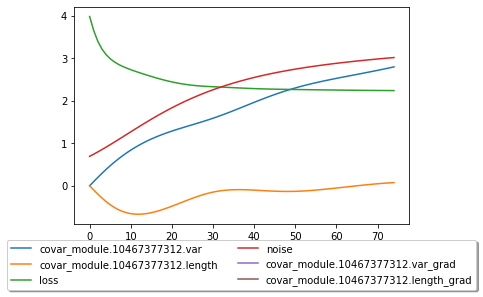

In [12]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [13]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([3.0280], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [14]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [15]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([2.9783], requires_grad=True))
('covar_module.10467377312.var', Parameter containing:
tensor(2.8212, requires_grad=True))
('covar_module.10467377312.length', Parameter containing:
tensor(0.0791, requires_grad=True))


In [16]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 1.6797e+01,  1.4340e+01,  1.6750e+01,  ..., -2.4737e-01,
          1.8161e-02, -1.9628e-01],
        [ 1.4340e+01,  3.6727e+01,  1.4218e+01,  ...,  1.6773e+00,
         -1.9628e-01,  1.4245e+00],
        [ 1.6750e+01,  1.4218e+01,  1.6797e+01,  ..., -3.0965e-01,
          2.3932e-02, -2.4737e-01],
        ...,
        [-2.4737e-01,  1.6773e+00, -3.0965e-01,  ...,  3.6727e+01,
          1.4218e+01,  3.6206e+01],
        [ 1.8161e-02, -1.9628e-01,  2.3932e-02,  ...,  1.4218e+01,
          1.6797e+01,  1.4340e+01],
        [-1.9628e-01,  1.4245e+00, -2.4737e-01,  ...,  3.6206e+01,
          1.4340e+01,  3.6727e+01]])
torch.return_types.eig(
eigenvalues=tensor([[ 7.4600e+02,  0.0000e+00],
        [ 7.1323e+02,  0.0000e+00],
        [ 4.8489e+02,  0.0000e+00],
        [ 3.8342e+02,  0.0000e+00],
        [ 1.8348e+02,  0.0000e+00],
        [ 7.9692e+01,  0.0000e+00],
        [ 5.4695e+01,  0.0000e+00],
        [ 2.4055e+01,  0.0000e+00],
        [ 5.6545e+00,  0.0000e+00],
        

Text(0.5, 1.0, 'Observed Values (Likelihood)')

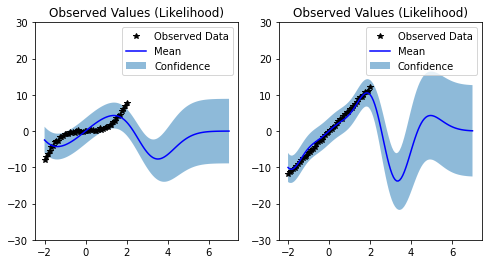

In [17]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [18]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [19]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [20]:
X = torch.linspace(float(-2), float(2), int(1))

In [21]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [22]:
def coeffs(given_n):
    # See http://oeis.org/A096713
    real_n = int(given_n/2)
    m, k = var('m, k')
    # even
    # T(2*m, k) = (-1)^(m+k)*(2*m)!*2^(k-m)/((m-k)!*(2*k)!), k = 0..m.
    if given_n % 2 == 0:
        # This notation is only valid in iPython
        #T(m,k) = factorial(2*m)*2^(k-m)/(factorial(m-k)*factorial(2*k))
        # As an actual Python file I need to use:
        T = lambda m, k : (-1)**(m+k)*factorial(2*m)*2**(k-m)/(factorial(m-k)*factorial(2*k))
    # odd
    # T(2*m+1, k) = (-1)^(m+k)*(2*m+1)!*2^(k-m)/((m-k)!*(2*k+1)!), k = 0..m. (End)
    else:
        # See above
        #T(m,k) = factorial(2*m+1)*2^(k-m)/(factorial(m-k)*factorial(2*k+1))
        T = lambda m, k: (-1)**(m+k)*factorial(2*m+1)*2**(k-m)/(factorial(m-k)*factorial(2*k+1))

    return [int(T(real_n, k)) for k in range(real_n+1)]


In [23]:
for n in range(13): 
    print(f"{n}: {coeffs(n)}")

0: [1]
1: [1]
2: [-1, 1]
3: [-3, 1]
4: [3, -6, 1]
5: [15, -10, 1]
6: [-15, 45, -15, 1]
7: [-105, 105, -21, 1]
8: [105, -420, 210, -28, 1]
9: [945, -1260, 378, -36, 1]
10: [-945, 4725, -3150, 630, -45, 1]
11: [-10395, 17325, -6930, 990, -55, 1]
12: [10395, -62370, 51975, -13860, 1485, -66, 1]


In [24]:
from sage.functions.hypergeometric import closed_form
def A096713_row(n):

    R.<z> = ZZ[]

    h = hypergeometric([-n/2, (1-n)/2], [], -2*z)
    T = R(closed_form(h)).coefficients()
    return T[::-1]

for n in range(13): 
    print(A096713_row(n))


[1]
[1]
[-1, 1]
[-3, 1]
[3, -6, 1]
[15, -10, 1]
[-15, 45, -15, 1]
[-105, 105, -21, 1]
[105, -420, 210, -28, 1]
[945, -1260, 378, -36, 1]
[-945, 4725, -3150, 630, -45, 1]
[-10395, 17325, -6930, 990, -55, 1]
[10395, -62370, 51975, -13860, 1485, -66, 1]


In [28]:
kernel = Diff_SE_kernel(var=0, length=0)
kernel2 = Diff_SE_kernel(var=0, length=0)
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (1, 0, dx1^3, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
p = DiffMatrixKernel([[kernel, None], [None, None]])
cov_mod = p.diff(left_matrix=L, right_matrix=R)
print(cov_mod)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]
[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 0, 0]]]

[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 3, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], -3, 2, 1], [[tensor(1.), tensor(1.)], 1, 3, 3]]]

[1,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 3, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], -15, 3, 1], [[tensor(1.), tensor(1.)], 10, 4, 3], [[tensor(1.), tensor(1.)], -1, 5, 5]]]




In [26]:
print(SE)
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2))
print(SE.diff(x1).diff(x2).diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> -15*sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^6 + 10*sigma^2*(x1 - x2)^3*e^(-1/2*(x1 - x2)^2/l^2)/l^8 - sigma^2*(x1 - x2)^5*e^(-1/2*(x1 - x2)^2/l^2)/l^10


In [27]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

TypeError: Integer.degree() takes no arguments (1 given)

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
a, b, c, d, x, y, dx1 = var('a, b, c, d, x, y, dx1')
poly = (a*(2*(c+b)+a)+a)*y
#poly = a*b*dx1**3
print(type(poly))
#poly = 839840583*x^75
print(poly.degree(dx1))
print(poly.operands())
print([op.is_numeric() for op in poly.operands()])

In [ ]:
return_list = []
l1 = [[42, 17], [128, 256]]
for i, l in enumerate(l1):
    if i == 0:
        func1 = lambda : l[0]*l[1]
        return_list.append(func1)
    else: 
        func2 = lambda : l[0]*l[1]
        return_list.append(func2)

for func in return_list:
    print(func())